# MONAI Deploy App SDK による簡単な画像処理アプリの作成

MONAI Deploy App SDK を使って、簡単な画像処理アプリを開発する方法を紹介します。

## ApplicationクラスでのOperatorの作成と接続

ここでは、3つのOperatorからなるアプリケーションを実装します。

- **SobelOperator**: ソーベルエッジ検出器を適用します。
    - **Input**: ファイルパス ([`DataPath`](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.DataPath.html))
    - **Output**: メモリ上の画像オブジェクト ([`Image`](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.Image.html))
- **MedianOperator**: ノイズ除去のためのメディアンフィルターを適用する。
    - **Input**: メモリ上の画像オブジェクト ([`Image`](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.Image.html))
    - **Output**: メモリ上の画像オブジェクト ([`Image`](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.Image.html))
- **GaussianOperator**: ガウシアンフィルタを適用し、平滑化する。
    - **Input**: メモリ上の画像オブジェクト ([`Image`](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.Image.html))
    - **Output**: ファイルパス ([`DataPath`](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.DataPath.html))
    
アプリケーションのワークフローは次のようになります。

```{mermaid}
%%{init: {"theme": "base", "themeVariables": { "fontSize": "16px"}} }%%

classDiagram
    direction LR

    SobelOperator --|> MedianOperator : image...image
    MedianOperator --|> GaussianOperator : image...image

    class SobelOperator {
        <in>image : DISK
        image(out) IN_MEMORY
    }
    class MedianOperator {
        <in>image : IN_MEMORY
        image(out) IN_MEMORY
    }
    class GaussianOperator {
        <in>image : IN_MEMORY
        image(out) DISK
    }
```

### 環境のセットアップ


In [1]:
# アプリケーションに必要な画像読み込み/処理パッケージのインストール
!python -c "import PIL" || pip install -q "Pillow"
!python -c "import skimage" || pip install -q "scikit-image"

# MONAI Deploy App SDK パッケージのインストール
!python -c "import monai.deploy" || pip install -q "monai-deploy-app-sdk"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 162 kB 14.7 MB/s 


### テスト画像のダウンロード

以下のデータをテスト画像として使用します。

> 症例提供：Dr Bruno Di Muzio, <a href="https://radiopaedia.org/?lang=us">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/41113?lang=us">rID: 41113</a>

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'wget'
Test input file path: /tmp/normal-brain-mri-4.png


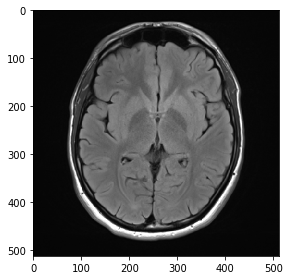

In [2]:
# テスト画像をwgetでダウンロードし、/tmp/normal-brain-mri-4.pngとして保存する
!python -c "import wget" || pip install -q "wget"

from skimage import io
import wget

test_input_path = "/tmp/normal-brain-mri-4.png"
wget.download("https://user-images.githubusercontent.com/1928522/133383228-2357d62d-316c-46ad-af8a-359b56f25c87.png", test_input_path)

print(f"Test input file path: {test_input_path}")

test_image = io.imread(test_input_path)
io.imshow(test_image)

### importのセットアップ

アプリケーションとオペレータを定義するために必要なクラスやデコレータをインポートします。

In [3]:
import monai.deploy.core as md  # 'md' はMONAI Deployの略です ('core' でも可)
from monai.deploy.core import (
    Application,
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)

### Operatorクラスの作成

Operatorクラスは [Operator](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.Operator.html) クラスを継承し、[@input](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.input.html)/[@output](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.output.html) デコレータで入出力のプロパティを指定します。

なお、最初のオペレータ（SobelOperator）の入力と最後のオペレータ（GaussianOperator）の出力は、[IOType.DISK](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.IOType.html)の [DataPath](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.DataPath.html)型です。これらのパスは、実行時にユーザーから与えられた入力と出力のパスにマッピングされます。

ビジネスロジックは<a href="https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.Operator.html#monai.deploy.core.Operator.compute">compute()</a>メソッドで実装されます。

#### SobelOperator

SobelOperatorは、最初の演算子です (A root operator in the workflow graph). <a href="https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.InputContext.html#monai.deploy.core.InputContext.get">op_input.get(label)</a> (この演算子では入力は1つしか定義されていないので、入力ラベルを指定する必要はありません) は[DataPath](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.DataPath.html)のオブジェクトを返し、入力ファイル/フォルダのパスは`path` プロパティ (`op_input.get().path`)にアクセスすれば利用可能です。

画像データ（Numpy配列）を読み込んで処理すると、画像データから[Image](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.Image.html) オブジェクトが生成され、出力に設定されます (<a href="https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.OutputContext.html#monai.deploy.core.OutputContext.set">op_output.set(value, label)</a>).

In [ ]:
@md.input("image", DataPath, IOType.DISK)
@md.output("image", Image, IOType.IN_MEMORY)
# `pip_packages` が指定された場合、パッケージング時に他のオペレータやアプリケーションのパッケージ依存リストと一緒に定義が集約されます。
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class SobelOperator(Operator):
    """このオペレータは、ソーベル・エッジ検出器を実装しています。

    入力と出力はそれぞれ1つずつです。
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage import filters, io

        input_path = op_input.get().path
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # 最初のファイルを取得します

        data_in = io.imread(input_path)[:, :, :3]  # アルファチャンネルが存在する場合、それを破棄します。
        data_out = filters.sobel(data_in)

        op_output.set(Image(data_out))

#### MedianOperator

MedianOperatorは、SobelOperatorからデータを受け取り、処理後の画像データをGaussianOperatorに渡す中間演算子です。

入出力データ型は[Image](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.Image.html) で、Numpy 配列のデータは  `asnumpy()` メソッド (`op_input.get().asnumpy()`) で得られます。

ここでも、画像データ（Numpy配列）を読み込んで処理すると、[Image](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.domain.Image.html)オブジェクトが生成されて出力に設定されます (<a href="https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.OutputContext.html#monai.deploy.core.OutputContext.set">op_output.set(value, label)</a>)。

In [ ]:
@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", Image, IOType.IN_MEMORY)
# `pip_packages`が指定された場合、パッケージング時に他のオペレータやアプリケーションのパッケージ依存リストと一緒に定義が集約されます。
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class MedianOperator(Operator):
    """このオペレータは、ノイズ除去を実装しています。

    アルゴリズムは、中央値演算子に基づいています。
    1つの入力を取り込み、1つの出力を提供します。
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import median

        data_in = op_input.get().asnumpy()
        data_out = median(data_in)
        op_output.set(Image(data_out))

#### GaussianOperator

GaussianOperatorは最後の演算子（ワークフローグラフの葉演算子）であり、この演算子の出力パスはユーザーが指定した出力フォルダにマッピングされるため、 `op_output` 変数にパスを設定することはできません（例： `op_output.set(Image(data_out))`).

その代わり、 `op_output.get().path` で出力パスを取得し、処理後の画像データをファイルに保存することができます。

In [4]:
@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", DataPath, IOType.DISK)
# If `pip_packages` が指定された場合、パッケージング時に他のオペレータやアプリケーションのパッケージ依存リストと一緒に定義が集約されます。
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class GaussianOperator(Operator):
    """このオペレータは、ガウシアンに基づく平滑化を実装しています。

    1つの入力を取り込み、1つの出力を提供します。
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import gaussian
        from skimage.io import imsave

        data_in = op_input.get().asnumpy()
        data_out = gaussian(data_in, sigma=0.2)

        output_folder = op_output.get().path
        output_path = output_folder / "final_output.png"
        imsave(output_path, data_out)

### アプリケーションクラスの作成

アプリケーションクラスは次のようなものです。

[Application](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.Application.html)クラスを継承した`App`クラスが定義されています。

リソースやパッケージの依存関係は [@resource](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.resource.html) と [@env](https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.env.html) デコレーターで指定します。

In [ ]:
@md.resource(cpu=1)
# pip_packages  には、requirements.txt ファイルへのパス(str)、またはパッケージのリストを指定します。
@md.env(pip_packages=["scikit-image >= 0.17.2"])
class App(Application):
    """これは非常に基本的なアプリケーションです。

    これは、MONAI Deployアプリケーションフレームワークを紹介するものです。
    """

    # アプリの名前。指定しない場合は、<クラス名>('App')となります。
    name = "simple_imaging_app"
    # アプリの説明文。 指定しない場合は、<class docstring>となります。
    description = "This is a very simple application."
    # アプリのバージョン。 指定しない場合は、<git version tag> または '0.0.0' となります。
    version = "0.1.0"

    def compose(self):
        """このアプリケーションには3つのオペレータがあります。

        各オペレータには、1つの入力ポートと1つの出力ポートがあります。
        各オペレータは、何らかの画像処理機能を実行します。
        """
        sobel_op = SobelOperator()
        median_op = MedianOperator()
        gaussian_op = GaussianOperator()

        self.add_flow(sobel_op, median_op)
        # self.add_flow(sobel_op, median_op, {"image": "image"})
        # self.add_flow(sobel_op, median_op, {"image": {"image"}})

        self.add_flow(median_op, gaussian_op)

`compose()` メソッドでは、`SobelOperator`, `MedianOperator`, and `GaussianOperator` クラスのオブジェクトを生成し、<a href="(https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/modules/_autosummary/monai.deploy.core.Application.html#monai.deploy.core.Application.add_flow">self.add_flow()</a>で接続します。

> add_flow(source_op, destination_op, io_map=None)

`io_map` は、接続元のオペレータのラベルから接続先のオペレータのラベルへのマッピングの辞書で、そのタイプは`Dict[str, str|Set[str]]`です。

We can skip specifying `io_map` の指定は、`source_op`の出力数と`destination_op`の入力数がともに1であれば省略できる。したがって、`self.add_flow(sobel_op, median_op)` は `self.add_flow(sobel_op, median_op, {"image": "image"})` または `self.add_flow(sobel_op, median_op, {"image": {"image"}})`と同じである。


## ローカルでアプリを実行する

Jupyterノートブック上でアプリを実行することができます。

In [ ]:
app = App()

In [ ]:
app.run(input=test_input_path, output="output")

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 55, Operator ID: be31bc09-46d1-4dc8-9cec-eb33266b669c)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 55, Operator ID: f7994a6f-000d-40bf-a622-304b173f78d7)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 55, Operator ID: 396f9c5f-3c2a-46c2-b012-e0a68ceb922c)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
[2022-09-29 13:51:26,812] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Done performing execution of operator GaussianOperator



In [ ]:
!ls output

final_output.png


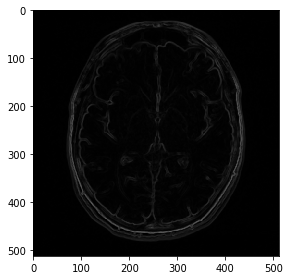

In [ ]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)

Jupyter notebook内でアプリケーションを確認したら、上記のPythonコードをアプリケーションフォルダ内のPythonファイルに書き込んでいくことができます。

アプリケーションフォルダは以下のような構成になります。:

```bash
simple_imaging_app
├── __main__.py
├── app.py
├── gaussian_operator.py
├── median_operator.py
└── sobel_operator.py
```

:::{note}
複数のファイルを作成する代わりに、ファイルの内容を含む1つのアプリケーションPythonファイル(`simple_imaging_app.py`など)を作成することができます。このような例は、<a href="https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/notebooks/tutorials/02_mednist_app.html#executing-app-locally">MedNist Classifier Tutorial</a>で見ることができます。
:::

In [ ]:
# アプリケーションフォルダーの作成
!mkdir -p simple_imaging_app

### sobel_operator.py

In [ ]:
%%writefile simple_imaging_app/sobel_operator.py
import monai.deploy.core as md
from monai.deploy.core import (
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)


@md.input("image", DataPath, IOType.DISK)
@md.output("image", Image, IOType.IN_MEMORY)
class SobelOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage import filters, io

        input_path = op_input.get().path
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # 最初のファイルを取る

        data_in = io.imread(input_path)[:, :, :3]  # アルファチャンネルが存在する場合は、それを破棄します。
        data_out = filters.sobel(data_in)

        op_output.set(Image(data_out))

Writing simple_imaging_app/sobel_operator.py


### median_operator.py

In [ ]:
%%writefile simple_imaging_app/median_operator.py
import monai.deploy.core as md
from monai.deploy.core import ExecutionContext, Image, InputContext, IOType, Operator, OutputContext, output


@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", Image, IOType.IN_MEMORY)
class MedianOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import median

        data_in = op_input.get().asnumpy()
        data_out = median(data_in)
        op_output.set(Image(data_out))

Writing simple_imaging_app/median_operator.py


### gaussian_operator.py

In [ ]:
%%writefile simple_imaging_app/gaussian_operator.py
import monai.deploy.core as md
from monai.deploy.core import (
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)


@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", DataPath, IOType.DISK)
class GaussianOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import gaussian
        from skimage.io import imsave

        data_in = op_input.get().asnumpy()
        data_out = gaussian(data_in, sigma=0.2)

        output_folder = op_output.get().path
        output_path = output_folder / "final_output.png"
        imsave(output_path, data_out)

Writing simple_imaging_app/gaussian_operator.py


### app.py

In [ ]:
%%writefile simple_imaging_app/app.py
import monai.deploy.core as md
from gaussian_operator import GaussianOperator
from median_operator import MedianOperator
from sobel_operator import SobelOperator

from monai.deploy.core import Application


@md.resource(cpu=1)
@md.env(pip_packages=["scikit-image >= 0.17.2"])
class App(Application):
    def compose(self):
        sobel_op = SobelOperator()
        median_op = MedianOperator()
        gaussian_op = GaussianOperator()

        self.add_flow(sobel_op, median_op)
        self.add_flow(median_op, gaussian_op)

# Run the application when this file is executed.
if __name__ == "__main__":
    App(do_run=True)

Writing simple_imaging_app/app.py


```python
if __name__ == "__main__":
    App(do_run=True)
```

上記の行は、`python`インタプリタを使ってアプリケーションコードを実行するために必要です。

### \_\_main\_\_.py

\_\_main\_\_.py は、<a href="https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/developing_with_sdk/packaging_app.html">MONAI Application Packager</a>  が、アプリケーションフォルダのパスでアプリケーションを実行したとき（例：`python simple_imaging_app`)、メインアプリケーションコード (`app.py`) を検出するために必要なものです。

In [ ]:
%%writefile simple_imaging_app/__main__.py
from app import App

if __name__ == "__main__":
    App(do_run=True)

Writing simple_imaging_app/__main__.py


In [ ]:
!ls simple_imaging_app

app.py		      __main__.py	  sobel_operator.py
gaussian_operator.py  median_operator.py


今回は、コマンドラインでアプリを実行してみましょう。

In [ ]:
!python simple_imaging_app -i {test_input_path} -o output

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 227, Operator ID: 845b5cb5-43b4-4484-82af-ea9ad16439ae)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 227, Operator ID: f9b72c7b-c727-4c02-94ac-266a466f4e14)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 227, Operator ID: ce9b4028-e98d-440a-bc3e-89e96a88d767)
simple_imaging_app/gaussian_operator.py:21: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
[2022-09-29 13:51:50,662] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Done performing execution of operato

上記のコマンドは、以下のコマンドラインと同じです。

In [ ]:
!monai-deploy exec simple_imaging_app -i {test_input_path} -o output

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 237, Operator ID: 90c77016-d1e0-4925-b401-c75ce85b5bfe)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 237, Operator ID: 806f752e-2990-4866-bb25-49c31f81bb52)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 237, Operator ID: 028d7e72-014d-4fd5-bb79-f97a9ee0981a)
simple_imaging_app/gaussian_operator.py:21: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  data_out = gaussian(data_in, sigma=0.2)
[2022-09-29 13:51:56,985] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

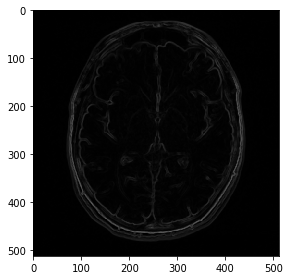

In [ ]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)

## Packaging app

<a href="../../developing_with_sdk/packaging_app.html">MONAI Application Packager</a>でアプリをパッケージングしてみましょう。

In [ ]:
!monai-deploy package simple_imaging_app --tag simple_app:latest  # -l DEBUG

Building MONAI Application Package... /bin/sh: 1: docker: not found
Done


:::{note}
MONAIアプリケーションパッケージ（Dockerイメージ）のビルドには、時間がかかることがあります。進捗を確認したい場合は、`-l DEBUG`オプションを使用します。

:::

Dockerイメージが作成されたことが確認できます。

In [ ]:
!docker image ls | grep simple_app

/bin/bash: docker: command not found


## パッケージ化されたアプリをローカルで実行する

パッケージ化されたアプリは、 <a href="https://docs.monai.io/projects/monai-deploy-app-sdk/en/latest/developing_with_sdk/executing_packaged_app_locally.html">MONAI Application Runner</a>を使って、ローカルで実行することができます。

In [ ]:
# テスト用入力ファイルを 'input' フォルダにコピーします。
!mkdir -p input && rm -rf input/*
!cp {test_input_path} input/

# Launch the app
!monai-deploy run simple_app:latest input output

Checking dependencies...
--> Verifying if "docker" is installed...

ERROR: "docker" not installed, please install docker.
Execution Aborted


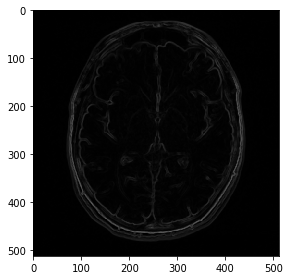

In [ ]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)